In [90]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2


from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import matplotlib.ticker as ticker
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from vit_keras import vit
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K

from image_load import *


In [2]:
img_size = 224
classes = ['no', 'yes']

#Create the Inception network
base_incep = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_incep.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

inception = Model(inputs=base_incep.input, outputs=predictions)

for layer in base_incep.layers:
    layer.trainable = False

inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])



#Create the Resnet network
base_resn = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
x = base_resn.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

resnet = Model(inputs=base_resn.input, outputs=predictions)

for layer in base_resn.layers:
    layer.trainable = False

resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])


In [3]:
#prepare data for training/evaluating and testing (differently done as kees, using the made python file)

images, labels = load_images_method_2(image_input_size=img_size)
images, labels = shuffle_data(images, labels)
labels = reformat_labels(labels)

x_train, y_train, x_val, y_val, x_test, y_test = split_data(images, labels)

inception_history = inception.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))

resnet_history = resnet.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))




Epoch 1/10
6/6 [==============================] - 23s 2s/step - loss: 37.2105 - binary_accuracy: 0.5650 - val_loss: 25.2041 - val_binary_accuracy: 0.6000
Epoch 2/10
6/6 [==============================] - 11s 2s/step - loss: 15.0055 - binary_accuracy: 0.6780 - val_loss: 5.5678 - val_binary_accuracy: 0.7600
Epoch 3/10
6/6 [==============================] - 11s 2s/step - loss: 7.1193 - binary_accuracy: 0.7797 - val_loss: 9.5190 - val_binary_accuracy: 0.7000
Epoch 4/10
6/6 [==============================] - 11s 2s/step - loss: 3.7983 - binary_accuracy: 0.8249 - val_loss: 5.8163 - val_binary_accuracy: 0.6600
Epoch 5/10
6/6 [==============================] - 11s 2s/step - loss: 4.4598 - binary_accuracy: 0.7345 - val_loss: 3.8583 - val_binary_accuracy: 0.8000
Epoch 6/10
6/6 [==============================] - 10s 2s/step - loss: 2.6357 - binary_accuracy: 0.8192 - val_loss: 3.9438 - val_binary_accuracy: 0.8000
Epoch 7/10
6/6 [==============================] - 11s 2s/step - loss: 1.8434 - binary

Text(0, 0.5, 'Accuracy')

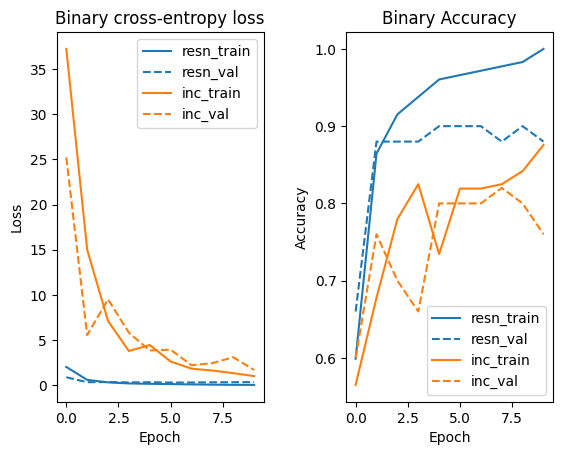

In [26]:
#NOTE we can split validation vs train loss/accuracy if we want, however it would be nice to have a pair-wise comparison,
#between these 2 as we can then explain under/overfitting etc.

#plotting loss/accuracy over epoch

data_dict = {}
data_dict["resn"] = resnet_history
data_dict["inc"] = inception_history

fig, axs = plt.subplots(1, 2)
fig.subplots_adjust(wspace=0.4)
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"] #nice standard matplotlib colors

#compute losses (train and validation)
color_idx = 0
for key, value in data_dict.items():
    axs[0].plot(value.history['loss'], label=f"{key}_train", color=colors[color_idx])
    axs[0].plot(value.history['val_loss'], label=f"{key}_val", linestyle="--", color=colors[color_idx])
    color_idx += 1

axs[0].set_title("Binary cross-entropy loss")
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

#compute accuracy (train and validation)

color_idx = 0
for key, value in data_dict.items():
    axs[1].plot(value.history['binary_accuracy'], label=f"{key}_train", color=colors[color_idx])
    axs[1].plot(value.history['val_binary_accuracy'], label=f"{key}_val", linestyle="--", color=colors[color_idx])
    color_idx += 1

axs[1].set_title("Binary Accuracy")
axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')


In [67]:
#Compute results with test data!


architectures = [resnet, inception]
model_names = ["resnet", "inception"]
result_dict = {}

for model, name in zip(architectures, model_names):
    result_dict[name] = model.evaluate(x_test, y_test)


1/1 [==============================] - 1s 904ms/step - loss: 0.8651 - binary_accuracy: 0.8077


Text(0, 0.5, 'Binary Accuracy')

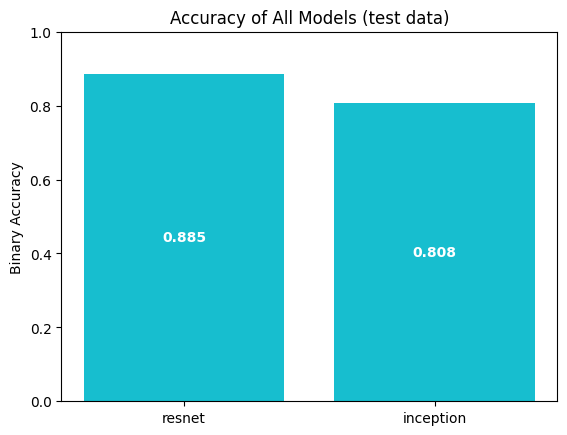

In [60]:
#plot using the testdata
#this plot may be redundant, and we can just note these values in the report?

fig, ax = plt.subplots()

losses = [loss_acc[0] for loss_acc in result_dict.values()]
bin_accuracies = [loss_acc[1] for loss_acc in result_dict.values()]

ax.bar(result_dict.keys(), bin_accuracies, color="tab:cyan")

#write accuracy within bar (looks nice :)
for i, v in enumerate(bin_accuracies):
    ax.text(i, v/2, str(round(v, 3)), color='white', fontweight='bold', ha='center', va='center')


ax.set_ylim(0, 1)
ax.set_title("Accuracy of All Models (test data)")
ax.set_ylabel("Binary Accuracy")

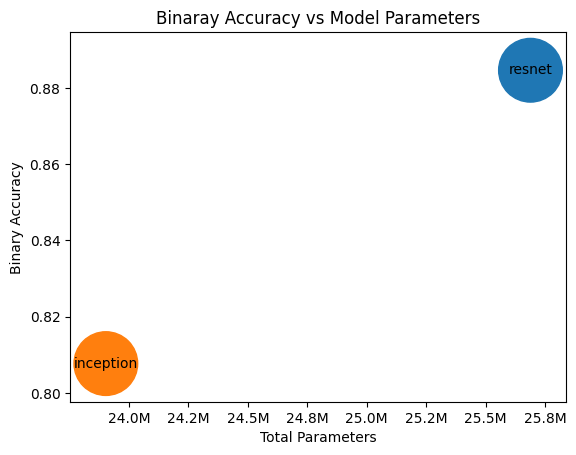

In [92]:
# scatterplot accuracy of the model vs amount of parameters

def millions_formatter(x, pos):
    return '{:.1f}M'.format(x*1e-6)


model_param_dict = {}

for model, name in zip(architectures, model_names):
    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

    model_param_dict[name] = [non_trainable_count, trainable_count]

    
bin_accuracies = [loss_acc[1] for loss_acc in result_dict.values()]

non_trainable_params = [params[0] for params in model_param_dict.values()] #1 for trainable, 0 for non trainable
trainable_params = [params[1] for params in model_param_dict.values()] #1 for trainable, 0 for non trainable
trainable_param_size = [params/1000 for params in trainable_params]
total_params = np.add(trainable_params, non_trainable_params)

plt.scatter(total_params, bin_accuracies, s=trainable_param_size, c= colors[:len(model_names)])

for idx, name in enumerate(model_names):
    plt.text(total_params[idx], bin_accuracies[idx], f'{name}', color="black",  ha='center', va='center')


#boundaries
plt.xlim([min(total_params)-150000, max(total_params)+150000])
plt.ylim([min(bin_accuracies)-0.01, max(bin_accuracies)+0.01])


# Set the plot title and axis labels
plt.title('Binaray Accuracy vs Model Parameters')

# format to millions on x-axis
formatter = ticker.FuncFormatter(millions_formatter)
plt.gca().xaxis.set_major_formatter(formatter)


plt.xlabel('Total Parameters')
plt.ylabel('Binary Accuracy')

# Show the plot
plt.show()
    
